In [5]:
import gpytorch
import pyreadr
from sklearn import preprocessing
import R_to_python_functions_analysis as RPY
#import hyperparameter_runner
import json
import pickle
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [6]:
lookup = RPY.get_user_ids()
rlookup = {v:k for k,v in lookup.items()}
uls = lookup.keys()

In [41]:
pd.to_datetime('10/19/19')+datetime.timedelta(days=20)

Timestamp('2019-11-08 00:00:00')

In [3]:
#x,y,locs,days = RPY.get_all_for_one_user('./data','10234')

In [4]:
#new_days = [dates[10234]+datetime.timedelta(days=(days[i]-1)) for i in range(len(days))]

In [7]:
def get_user_policy_date_specific(user_id,date):
    
    day = date.day
    if day<10:
        day='0{}'.format(day)
    else:
        day=str(day)
        
    formatted_date = '{}-{}-{}'.format(date.year,date.month,day)
    #print(formatted_date)
    if formatted_date == '2019-10-25':
        formatted_date = '2019-10-24'
    try:
        with open('data/test_{}.pkl'.format(formatted_date),'rb') as f:
            test = pickle.load(f)
    
    #print(test.keys())
        user_id = lookup[str(user_id)]
        if user_id in test:
            return test[user_id]
        else:
            return 'not found'
    except:
        return 'no file'

In [8]:
def plot(user_id):
    
    dates = join_dates()
    x,y,locs,days,probs = RPY.get_all_for_one_user('./data',str(user_id))
    udates = [dates[user_id]+datetime.timedelta(days=(days[i]-1)) for i in range(len(days))]
    ##skip prior for now
    to_plot_y = []
    to_plot_dates = []
    to_color_locs = []
    yerrs = []
    probsr = []
    for i in range(len(x)):
        if days[i]>7:
            #-datetime.timedelta(days=(1))
            policy = get_user_policy_date_specific(user_id,udates[i])
            if type(policy)!=str:
                effect = np.dot(x[i][-5:],policy[0])
                std = np.dot(np.dot(x[i][-5:],policy[1]),x[i][-5:])
                yerrs.append(std**.5)
                to_plot_y.append(effect)
                to_plot_dates.append(udates[i])
                to_color_locs.append(locs[i])
                probsr.append(probs[i])
    return to_plot_y,to_plot_dates,to_color_locs,yerrs,probsr

In [9]:
def join_dates():
    dates = pd.DataFrame.from_csv('join_dates.csv')
    return {i:pd.to_datetime(r) for i,r in dates['join_date'].iteritems() }

In [8]:
#x,y,locs,days,yerr = RPY.get_all_for_one_user('./data',str(10152))

In [10]:
dates=join_dates()

In [10]:
#dates[10152]+datetime.timedelta(days=23)

In [11]:
def get_xticks(labels):
    seen = set([])
    to_plot = []
    for l in labels:
        if l not in seen:
            seen.add(l)
            to_plot.append(str(l.date()))
        else:
            to_plot.append('')
    return to_plot

In [12]:
def plot_a_user(probs,timelabels,colors,yerr,uid,real_probs):
    timelabels=get_xticks(timelabels)
    clocs = ['r' if l==0 else 'b' for l in colors]
    labels = ['Home/work' if l==0 else 'Other' for l in colors]
    x=plt.scatter([i for i in range(len(probs)) if clocs[i]=='r'],[probs[i] for i in range(len(probs)) if clocs[i]=='r'],c='r' ,label='Home/work')
    y=plt.scatter([i for i in range(len(probs)) if clocs[i]=='b'],[probs[i] for i in range(len(probs)) if clocs[i]=='b'],c='b',label='Other' )
    #x=plt.scatter([i for i in range(len(probs))],probs,c=clocs )
    plt.errorbar([i for i in range(len(probs))],probs,yerr=yerr)
    plt.ylabel('Posterior mean of treatment effect')
    plt.xlabel('Date')
    z= plt.plot([i for i in range(len(real_probs))],real_probs,c='g',label='Probabilities')
    #plt.legend((x,y,z),('Home/work','Other','P'))
    plt.legend()
    plt.title('User {}'.format(uid))
    
    plt.xticks([i for i in range(len(probs))],timelabels,rotation = 45,)
    plt.tight_layout()
    #plt.savefig('plots_11_7/participant_treatment_effect_{}'.format(uid))
    plt.show()
    

In [36]:
with open('data/test_2019-11-07.pkl','rb') as f:
    t = pickle.load(f)

In [31]:
lookup

{'10237': 0,
 '10271': 1,
 '10041': 2,
 '10355': 3,
 '10062': 4,
 '10374': 5,
 '10215': 6,
 '10313': 7,
 '10395': 8,
 '10152': 9,
 '10194': 10,
 '10259': 11,
 '10339': 12,
 '10360': 13,
 '10269': 14,
 '10234': 15,
 '10365': 16,
 '10352': 17,
 '10336': 18,
 '10304': 19}

In [4]:
x,y,locs,days,probs = RPY.get_all_for_one_user('./data',str(10259))

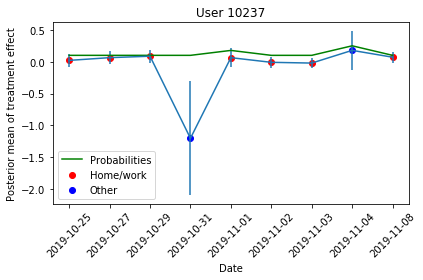

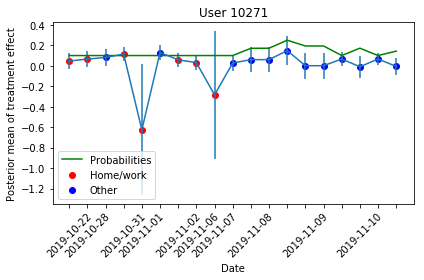

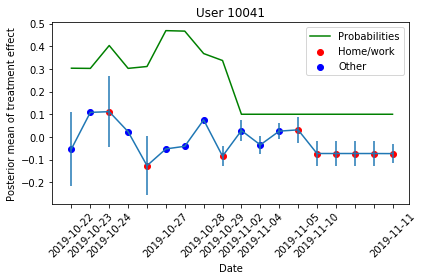

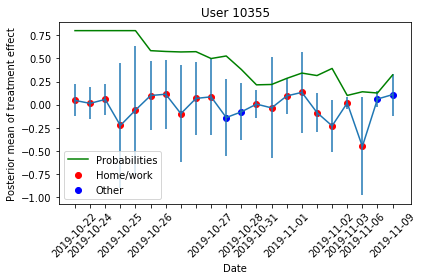

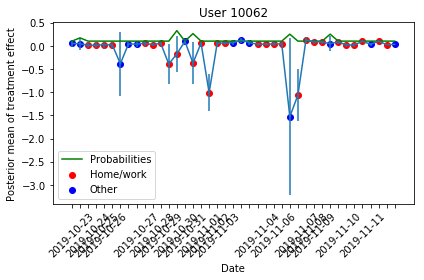

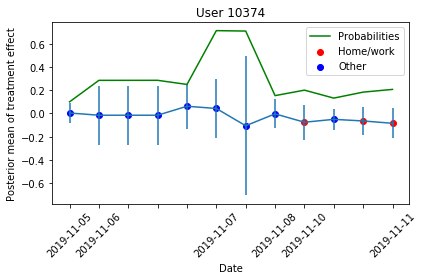

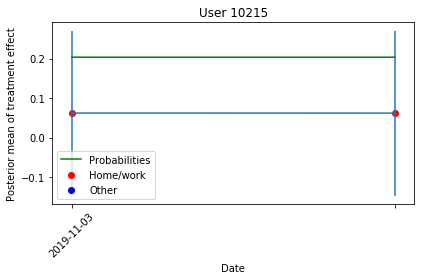

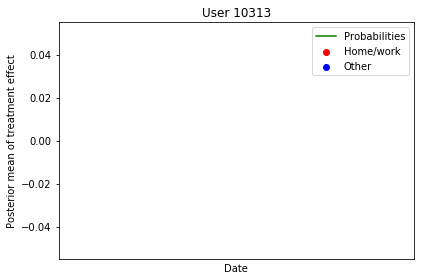

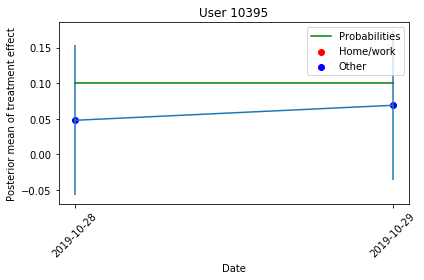

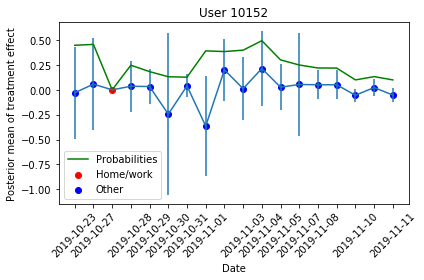

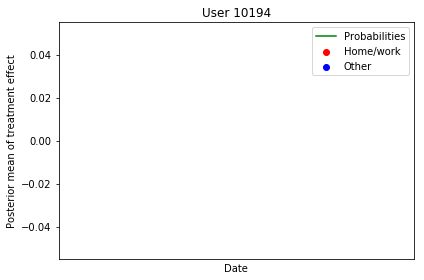

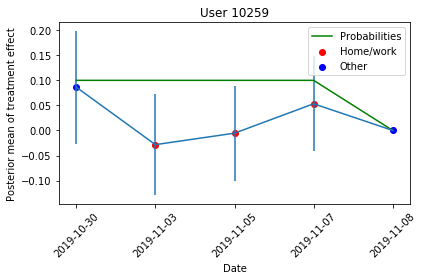

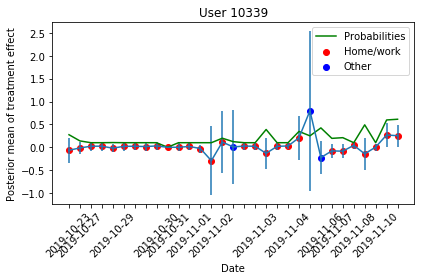

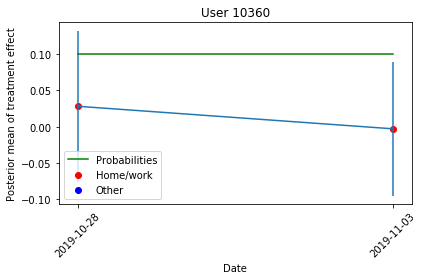

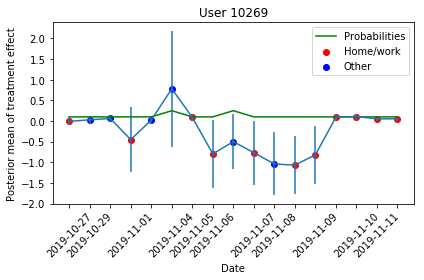

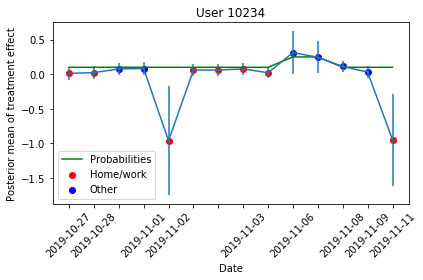

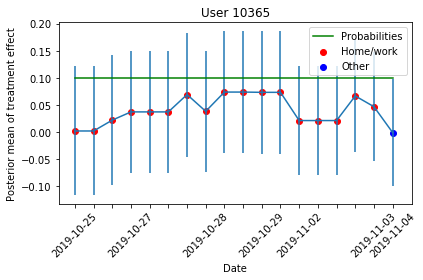

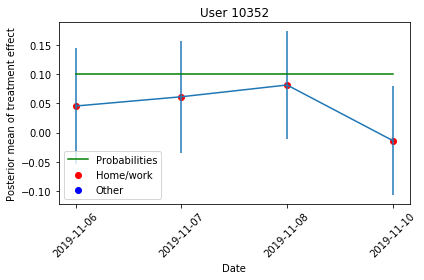

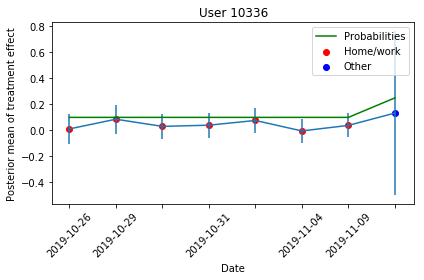

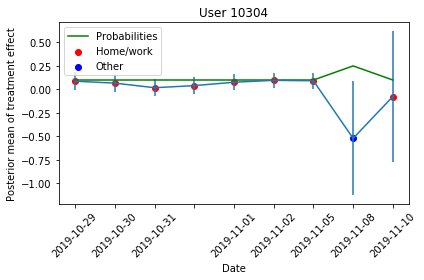

In [13]:
for u in uls:
    #[10365,10336,10339,10259,10234,10269,10304,10360]
    if int(u) in dates:
        y,labels,colors,yerr,real_probs = plot(int(u))
        plot_a_user(y,labels,colors,yerr,str(u),real_probs)

In [37]:
yerr

[0.09767884019317181,
 0.09753244667755713,
 0.8110590014595247,
 0.09511803451169103,
 1.4464747454516478,
 0.08958449611977609,
 0.82213081378225,
 0.6905441877646243]

In [14]:
def get_all_probs_all_locs():
    ap=[]
    al=[]
    for k,v in lookup.items():
        if v in by_users:
            probs,locs = get_f_and_loc( k,by_users)
            ap.extend(probs)
            al.extend(locs)
    return ap,al

In [15]:
ap,al = get_all_probs_all_locs()

NameError: name 'by_users' is not defined

In [101]:
np.mean(np.array([int(ap[i]>0) for i in range(len(ap)) if al[i]==0]))

0.6948529411764706

In [102]:
np.mean(np.array([int(ap[i]>0)  for i in range(len(ap)) if al[i]==1]))

0.5569620253164557

In [43]:
(5*(-2)+0*1) * .05 +((4*(-1)+1*1) * .05) +((3*(-2)+2*1) * .05)+((2*(-2)+3*1) * .05)+((1*(-2)+4*1) * .5)+(0*(-2)+5*1) * .3

1.5999999999999999